<a href="https://colab.research.google.com/github/alessandronascimento/HP_LiBELa/blob/master/Colab/HP_LiBELa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HP LiBELa

HP LiBELa is a 2D lattice-based computational tool to simulate the binding of a ligand in a binding site. It is based on the HP models for protein folding, but with the purpose of studying ligand binding to folded proteins.

Our hope is that this tool can be useful for teaching purposes, as well as to provide insights to the scoring of protein ligand interactions.


## The model

Typical lattices are designed like the one show below

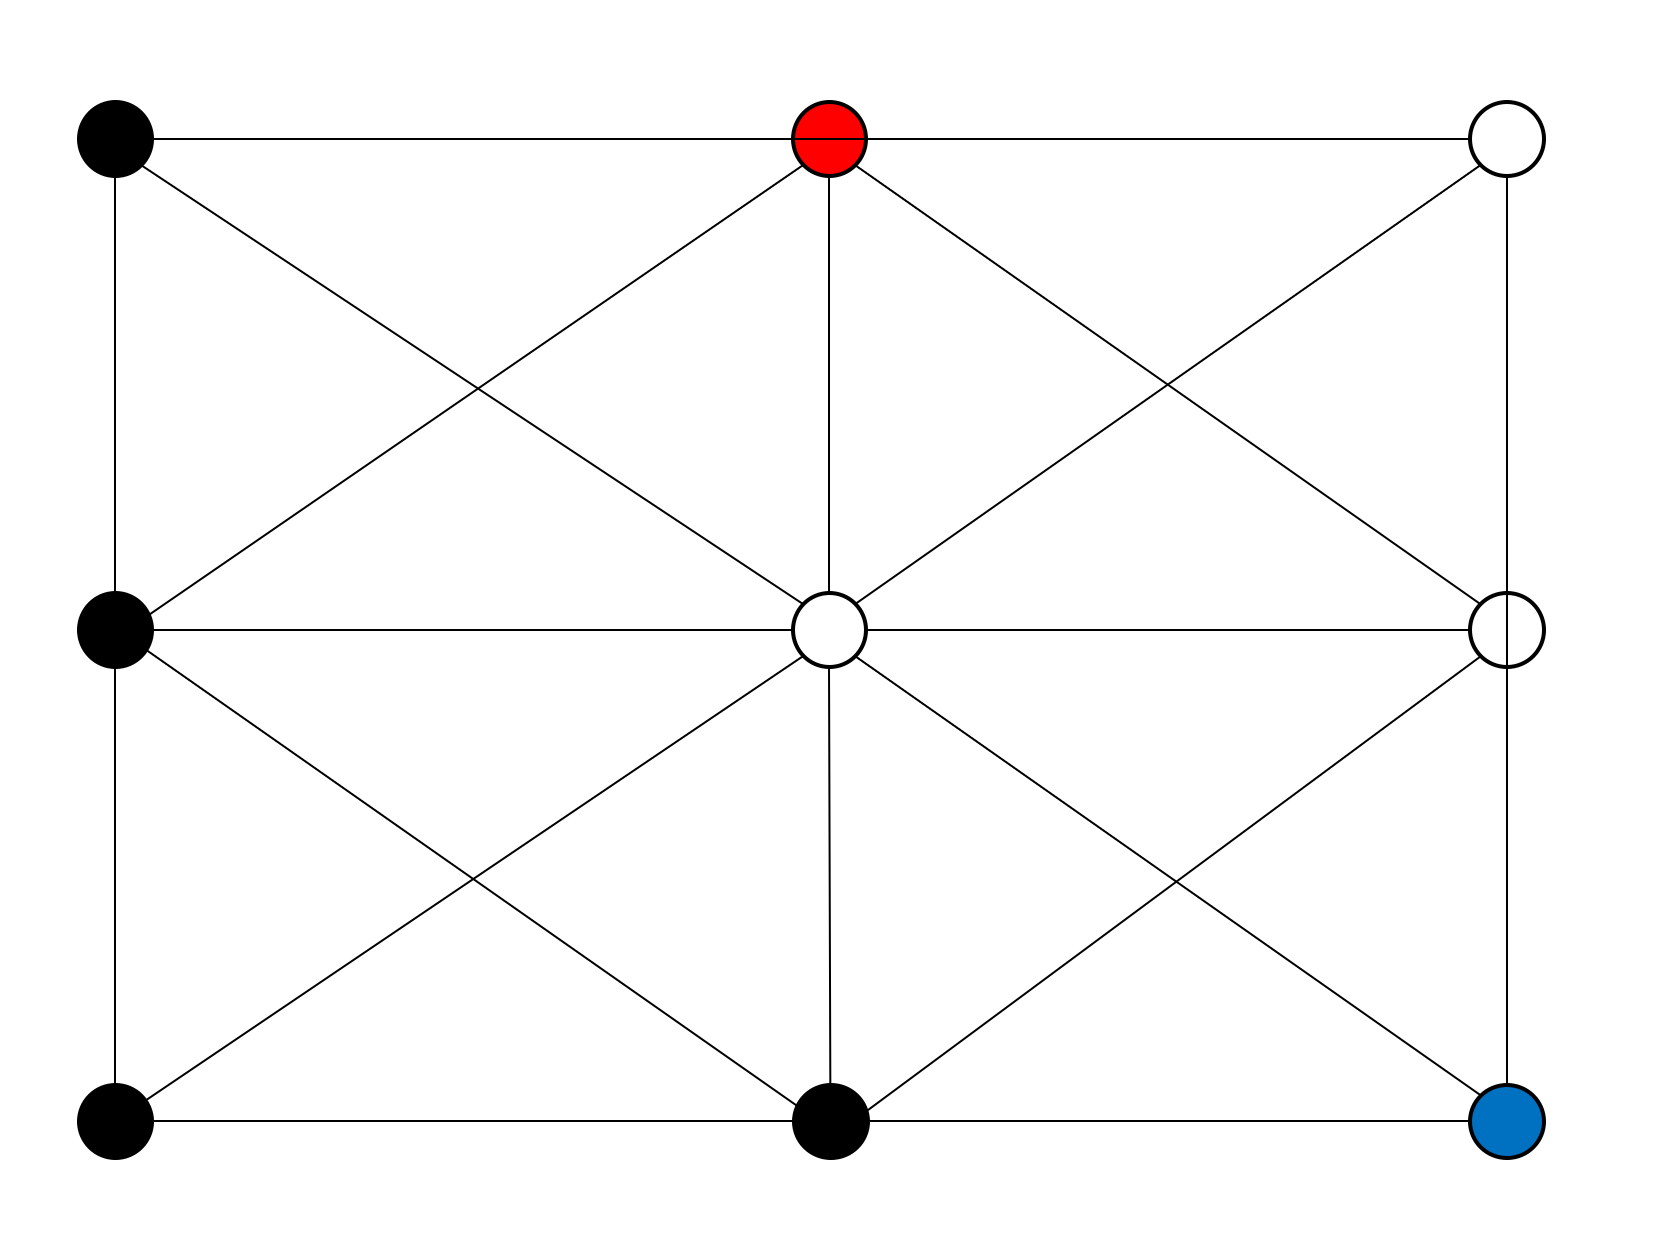

The black points indicate an lattice site that is occupied by a hydrophobic atom fo the receptor. The blue points indicate a lattice site that is occupied by a positively charged receptor atom (or a hydrogen bond donnor group) and the red points indicate a lattice site that is occupied by a negatively charged receptor atom (or a hydrogen bond acceptor group).

The ligand is typically modeled as a triangle with one hydrophobic atom, one positively-charged atom and one negatively-charged atom. The ligand has rotational and translational degrees of freedom within the lattice.

## The scoring model

The interactions between the ligand and the receptor (lattice) are computed in an additive way: Each hydrophobic contact is scored with and energy $\epsilon$, while each polar contact is scored with a $\alpha \epsilon$ interaction energy.

In [1]:
# @title Installing environment
%%capture
!apt-get install libgsl-dev
! git clone https://github.com/alessandronascimento/HP_LiBELa.git
%cd HP_LiBELa/bin
!make

# How to use:



1.   Define a temperature;
2.   Define your scoring parameters ($\alpha$ and $ϵ$);
3.   if you want to analyze the binding thermodynamic parameters as a function of the temperature, define the temperature range (ti, tf and dt);
4.   We provide, a few lattices (more can be generated in simple text files). You can choose among a 'typical' lattice, a [hydrophobic lattice](https://github.com/alessandronascimento/HP_LiBELa/blob/master/etc/hydrophobic_pocket.lattice), a [large pocket](https://github.com/alessandronascimento/HP_LiBELa/blob/master/etc/big_pocket.lattice), a [tight pocket](https://github.com/alessandronascimento/HP_LiBELa/blob/master/etc/tight_buried_pocket.lattice) or a [two-binding site lattice](https://github.com/alessandronascimento/HP_LiBELa/blob/master/etc/two_sites.lattice). Of course, you can also test all of them!
5.   In case you might want to try, there is an option to run a Monte Carlo simulation of the ligand within the lattice.
6.   Of course, we can also run the MC simulation for decreasing temperatures, in a simulated annealing scheme.



In [ ]:
# @title Setting variables

import matplotlib.pyplot as plt
from pyLattice import *
from pyMonteCarlo import *
from pyThermo import *
import numpy as np

verbose = False # @param {type:"boolean"}
mc_steps = 1000000 # @param {type:"integer"}
single_temp = False # @param {type:"boolean"}
temperature = 100.0 # @param {type:"number"}
alpha = 2.0 # @param {type:"number"}
epsilon = -0.5 # @param {type:"number"}
read_file = False # @param {type:"boolean"}

ti = 25.0 # @param {type:"number"}
tf = 3000.0 # @param {type:"number"}
dt = 25.0 # @param {type:"number"}

polar_epsilon = alpha*epsilon;


print("**********************************************************************");
print("***                                                                ***");
print("***                          HP - LiBELA                           ***");
print("***                                                                ***");
print("***  A minimalist lattice model for ligand binding thermodynamics  ***");
print("***                                                                ***");
print("***         Written by Alessandro S. Nascimento - IFSC/USP         ***");
print("***                       asnascimento@ifsc.usp.br                 ***");
print("***                                                                ***");
print("***                            August/2020                         ***");
print("***                                                                ***");
print("**********************************************************************");

print("***");
print("*** Parameters:");
print("*** Ti = %5.3f" % ti);
print("*** Tf = %5.3f" % tf);
print("*** dT = %5.3f" % dt);
print("*** T  = %5.3f" % temperature);
print("*** <epsilon> = %5.3f" % epsilon);
print("*** <epsilon_polar> = <alpha * epsilon> = %5.3f" % polar_epsilon);
print("***");
print("***                                                                ***");
print("**********************************************************************");


In [ ]:
# @title HP Modeling
Binding_Lattice = Lattice(epsilon, polar_epsilon, verbose);
Binding_Lattice.create_binding_lattice();
Binding_Lattice.create_ligand();
Binding_Lattice.print_lattice();
Binding_Lattice.print_ligand();

if (single_temp):
  ThermoData = Thermo(Binding_Lattice, (0.001985875*temperature));
else:
  ThermoData = Thermo(Binding_Lattice, ti, tf, dt);


Empty_Lattice = Lattice(epsilon, polar_epsilon, verbose);
Empty_Lattice.create_empty_binding_lattice();
Empty_Lattice.create_ligand();
Empty_Lattice.print_lattice();

if (single_temp):
  ThermoData2 = Thermo(Empty_Lattice, (0.001985875*temperature));
else:
  ThermoData2 = Thermo(Empty_Lattice, ti, tf, dt);

Ts = [];
dFs = [];
dUs = [];
dSs = [];

if ( not single_temp):
#  print("#Binding_Data: %10s %10s %10s %10s %10s" % ("Temp(K)", "dF", "dU", "dS", "-TdS"));
  for i in range(len(ThermoData.vlnQ)-1):
    dF = ThermoData.F[i] - ThermoData2.F[i];
    dU = ThermoData.U[i] - ThermoData2.U[i];
    dS = ThermoData.S[i] - ThermoData2.S[i];
#    print("Binding_Data: %10.5f %10.5f %10.5f %10.5f %10.5f" % (ThermoData.vt[i], dF, dU, dS, -ThermoData.vt[i]*dS));
    Ts.append(ThermoData.vt[i])
    dFs.append(dF)
    dUs.append(dU)
    dSs.append(dS)

  Binding_Lattice.print_line();
  Binding_Lattice.print_line();

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
    ax.set_title(f' {names} vs T')
    ax.plot(Ts, i, 'o', ls='-', ms=4)

else:
#  print("#Binding_Data: %10s %10s %10s %10s %10s", "Temp(K)", "dF", "dU", "dS", "-TdS");
  dF = ThermoData.single_F - ThermoData2.single_F;
  dU = ThermoData.single_U - ThermoData2.single_U;
  dS = ThermoData.single_S - ThermoData2.single_S;
#  print("Binding_Data: %10.5f %10.5f %10.5f %10.5f %10.5f" % (temperature, dF, dU, dS, -temperature*dS));
  Ts.append(temperature)
  dFs.append(dF)
  dUs.append(dU)
  dSs.append(dS)
  Binding_Lattice.print_line();
  Binding_Lattice.print_line();

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
    ax.set_title(f' {names} vs T')
    ax.plot(Ts, i, 'o', ls='-', ms=4)


In [ ]:
# @title Binding as a Function of the Interaction Energies

alpha_start = -3.25 # @param {type:"number"}
alpha_end = 3.25 # @param {type:"number"}
alpha_step = 0.25 # @param {type:"number"}

polar_epsilons = [];
dFs = [];
dUs = [];
dSs = [];



for alpha in np.arange(alpha_start, alpha_end, alpha_step):
  polar_epsilon = alpha*epsilon;
  polar_epsilons.append(polar_epsilon);

  Binding_Lattice = Lattice(epsilon, polar_epsilon, verbose);
  Binding_Lattice.create_binding_lattice();
  Binding_Lattice.create_ligand();
  ThermoData = Thermo(Binding_Lattice, (0.001985875*temperature));

  Empty_Lattice = Lattice(epsilon, polar_epsilon, verbose);
  Empty_Lattice.create_empty_binding_lattice();
  Empty_Lattice.create_ligand();
  ThermoData2 = Thermo(Empty_Lattice, (0.001985875*temperature));

  dF = ThermoData.single_F - ThermoData2.single_F;
  dU = ThermoData.single_U - ThermoData2.single_U;
  dS = ThermoData.single_S - ThermoData2.single_S;
  dFs.append(dF)
  dUs.append(dU)
  dSs.append(dS)


fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
  ax.set_title(f' {names} vs polar epsilon')
  ax.plot(polar_epsilons, i, 'o', ls='-', ms=4)

In [ ]:
# @title Hydrophobic Binding Site
Binding_Lattice = Lattice(epsilon, polar_epsilon, verbose);
Binding_Lattice.read_lattice_from_file('../etc/hydrophobic_pocket.lattice');
Binding_Lattice.create_ligand();
Binding_Lattice.print_lattice();
Binding_Lattice.print_ligand();

if (single_temp):
  ThermoData = Thermo(Binding_Lattice, (0.001985875*temperature));
else:
  ThermoData = Thermo(Binding_Lattice, ti, tf, dt);


Empty_Lattice = Lattice(epsilon, polar_epsilon, verbose);
Empty_Lattice.create_empty_binding_lattice();
Empty_Lattice.create_ligand();
Empty_Lattice.print_lattice();

if (single_temp):
  ThermoData2 = Thermo(Empty_Lattice, (0.001985875*temperature));
else:
  ThermoData2 = Thermo(Empty_Lattice, ti, tf, dt);

Ts = [];
dFs = [];
dUs = [];
dSs = [];

if ( not single_temp):
#  print("#Binding_Data: %10s %10s %10s %10s %10s" % ("Temp(K)", "dF", "dU", "dS", "-TdS"));
  for i in range(len(ThermoData.vlnQ)-1):
    dF = ThermoData.F[i] - ThermoData2.F[i];
    dU = ThermoData.U[i] - ThermoData2.U[i];
    dS = ThermoData.S[i] - ThermoData2.S[i];
#    print("Binding_Data: %10.5f %10.5f %10.5f %10.5f %10.5f" % (ThermoData.vt[i], dF, dU, dS, -ThermoData.vt[i]*dS));
    Ts.append(ThermoData.vt[i])
    dFs.append(dF)
    dUs.append(dU)
    dSs.append(dS)

  Binding_Lattice.print_line();
  Binding_Lattice.print_line();

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
    ax.set_title(f' {names} vs T')
    ax.plot(Ts, i, 'o', ls='-', ms=4)

else:
#  print("#Binding_Data: %10s %10s %10s %10s %10s", "Temp(K)", "dF", "dU", "dS", "-TdS");
  dF = ThermoData.single_F - ThermoData2.single_F;
  dU = ThermoData.single_U - ThermoData2.single_U;
  dS = ThermoData.single_S - ThermoData2.single_S;
#  print("Binding_Data: %10.5f %10.5f %10.5f %10.5f %10.5f" % (temperature, dF, dU, dS, -temperature*dS));
  Ts.append(temperature)
  dFs.append(dF)
  dUs.append(dU)
  dSs.append(dS)
  Binding_Lattice.print_line();
  Binding_Lattice.print_line();

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
    ax.set_title(f' {names} vs T')
    ax.plot(Ts, i, 'o', ls='-', ms=4)


In [ ]:
# @title Large Binding Pocket
Binding_Lattice = Lattice(epsilon, polar_epsilon, verbose);
Binding_Lattice.read_lattice_from_file('../etc/big_pocket.lattice');
Binding_Lattice.create_ligand();
Binding_Lattice.print_lattice();
Binding_Lattice.print_ligand();

if (single_temp):
  ThermoData = Thermo(Binding_Lattice, (0.001985875*temperature));
else:
  ThermoData = Thermo(Binding_Lattice, ti, tf, dt);


Empty_Lattice = Lattice(epsilon, polar_epsilon, verbose);
Empty_Lattice.create_empty_binding_lattice();
Empty_Lattice.create_ligand();
Empty_Lattice.print_lattice();

if (single_temp):
  ThermoData2 = Thermo(Empty_Lattice, (0.001985875*temperature));
else:
  ThermoData2 = Thermo(Empty_Lattice, ti, tf, dt);

Ts = [];
dFs = [];
dUs = [];
dSs = [];

if ( not single_temp):
#  print("#Binding_Data: %10s %10s %10s %10s %10s" % ("Temp(K)", "dF", "dU", "dS", "-TdS"));
  for i in range(len(ThermoData.vlnQ)-1):
    dF = ThermoData.F[i] - ThermoData2.F[i];
    dU = ThermoData.U[i] - ThermoData2.U[i];
    dS = ThermoData.S[i] - ThermoData2.S[i];
#    print("Binding_Data: %10.5f %10.5f %10.5f %10.5f %10.5f" % (ThermoData.vt[i], dF, dU, dS, -ThermoData.vt[i]*dS));
    Ts.append(ThermoData.vt[i])
    dFs.append(dF)
    dUs.append(dU)
    dSs.append(dS)

  Binding_Lattice.print_line();
  Binding_Lattice.print_line();

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
    ax.set_title(f' {names} vs T')
    ax.plot(Ts, i, 'o', ls='-', ms=4)

else:
#  print("#Binding_Data: %10s %10s %10s %10s %10s", "Temp(K)", "dF", "dU", "dS", "-TdS");
  dF = ThermoData.single_F - ThermoData2.single_F;
  dU = ThermoData.single_U - ThermoData2.single_U;
  dS = ThermoData.single_S - ThermoData2.single_S;
#  print("Binding_Data: %10.5f %10.5f %10.5f %10.5f %10.5f" % (temperature, dF, dU, dS, -temperature*dS));
  Ts.append(temperature)
  dFs.append(dF)
  dUs.append(dU)
  dSs.append(dS)
  Binding_Lattice.print_line();
  Binding_Lattice.print_line();

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
    ax.set_title(f' {names} vs T')
    ax.plot(Ts, i, 'o', ls='-', ms=4)

In [ ]:
# @title Tight Binding Pocket
Binding_Lattice = Lattice(epsilon, polar_epsilon, verbose);
Binding_Lattice.read_lattice_from_file('../etc/tight_buried_pocket.lattice');
Binding_Lattice.create_ligand();
Binding_Lattice.print_lattice();
Binding_Lattice.print_ligand();

if (single_temp):
  ThermoData = Thermo(Binding_Lattice, (0.001985875*temperature));
else:
  ThermoData = Thermo(Binding_Lattice, ti, tf, dt);


Empty_Lattice = Lattice(epsilon, polar_epsilon, verbose);
Empty_Lattice.create_empty_binding_lattice();
Empty_Lattice.create_ligand();
Empty_Lattice.print_lattice();

if (single_temp):
  ThermoData2 = Thermo(Empty_Lattice, (0.001985875*temperature));
else:
  ThermoData2 = Thermo(Empty_Lattice, ti, tf, dt);

Ts = [];
dFs = [];
dUs = [];
dSs = [];

if ( not single_temp):
#  print("#Binding_Data: %10s %10s %10s %10s %10s" % ("Temp(K)", "dF", "dU", "dS", "-TdS"));
  for i in range(len(ThermoData.vlnQ)-1):
    dF = ThermoData.F[i] - ThermoData2.F[i];
    dU = ThermoData.U[i] - ThermoData2.U[i];
    dS = ThermoData.S[i] - ThermoData2.S[i];
#    print("Binding_Data: %10.5f %10.5f %10.5f %10.5f %10.5f" % (ThermoData.vt[i], dF, dU, dS, -ThermoData.vt[i]*dS));
    Ts.append(ThermoData.vt[i])
    dFs.append(dF)
    dUs.append(dU)
    dSs.append(dS)

  Binding_Lattice.print_line();
  Binding_Lattice.print_line();

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
    ax.set_title(f' {names} vs T')
    ax.plot(Ts, i, 'o', ls='-', ms=4)

else:
#  print("#Binding_Data: %10s %10s %10s %10s %10s", "Temp(K)", "dF", "dU", "dS", "-TdS");
  dF = ThermoData.single_F - ThermoData2.single_F;
  dU = ThermoData.single_U - ThermoData2.single_U;
  dS = ThermoData.single_S - ThermoData2.single_S;
#  print("Binding_Data: %10.5f %10.5f %10.5f %10.5f %10.5f" % (temperature, dF, dU, dS, -temperature*dS));
  Ts.append(temperature)
  dFs.append(dF)
  dUs.append(dU)
  dSs.append(dS)
  Binding_Lattice.print_line();
  Binding_Lattice.print_line();

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
    ax.set_title(f' {names} vs T')
    ax.plot(Ts, i, 'o', ls='-', ms=4)

In [ ]:
# @title Two Binding Sites Lattice
Binding_Lattice = Lattice(epsilon, polar_epsilon, verbose);
Binding_Lattice.read_lattice_from_file('../etc/two_sites.lattice');
Binding_Lattice.create_ligand();
Binding_Lattice.print_lattice();
Binding_Lattice.print_ligand();

if (single_temp):
  ThermoData = Thermo(Binding_Lattice, (0.001985875*temperature));
else:
  ThermoData = Thermo(Binding_Lattice, ti, tf, dt);


Empty_Lattice = Lattice(epsilon, polar_epsilon, verbose);
Empty_Lattice.create_empty_binding_lattice();
Empty_Lattice.create_ligand();
Empty_Lattice.print_lattice();

if (single_temp):
  ThermoData2 = Thermo(Empty_Lattice, (0.001985875*temperature));
else:
  ThermoData2 = Thermo(Empty_Lattice, ti, tf, dt);

Ts = [];
dFs = [];
dUs = [];
dSs = [];

if ( not single_temp):
#  print("#Binding_Data: %10s %10s %10s %10s %10s" % ("Temp(K)", "dF", "dU", "dS", "-TdS"));
  for i in range(len(ThermoData.vlnQ)-1):
    dF = ThermoData.F[i] - ThermoData2.F[i];
    dU = ThermoData.U[i] - ThermoData2.U[i];
    dS = ThermoData.S[i] - ThermoData2.S[i];
#    print("Binding_Data: %10.5f %10.5f %10.5f %10.5f %10.5f" % (ThermoData.vt[i], dF, dU, dS, -ThermoData.vt[i]*dS));
    Ts.append(ThermoData.vt[i])
    dFs.append(dF)
    dUs.append(dU)
    dSs.append(dS)

  Binding_Lattice.print_line();
  Binding_Lattice.print_line();

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
    ax.set_title(f' {names} vs T')
    ax.plot(Ts, i, 'o', ls='-', ms=4)

else:
#  print("#Binding_Data: %10s %10s %10s %10s %10s", "Temp(K)", "dF", "dU", "dS", "-TdS");
  dF = ThermoData.single_F - ThermoData2.single_F;
  dU = ThermoData.single_U - ThermoData2.single_U;
  dS = ThermoData.single_S - ThermoData2.single_S;
#  print("Binding_Data: %10.5f %10.5f %10.5f %10.5f %10.5f" % (temperature, dF, dU, dS, -temperature*dS));
  Ts.append(temperature)
  dFs.append(dF)
  dUs.append(dU)
  dSs.append(dS)
  Binding_Lattice.print_line();
  Binding_Lattice.print_line();

  fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [dFs, dUs, dSs, dFs], ['dF', 'dU','dS','dF']):
    ax.set_title(f' {names} vs T')
    ax.plot(Ts, i, 'o', ls='-', ms=4)

In [ ]:
# @title Monte Carlo

print("Staring MC calculation...");
MC = MonteCarlo(Binding_Lattice, temperature, mc_steps);

fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
for ax,i,names in zip(axs.flat, [MC.scores, MC.frac_accept, MC.frac_bound, MC.scores], ['Scores', 'FracAccept','FracBound','Scores']):
  ax.set_title(f' MC Step vs {names}')
  ax.plot(MC.steps, i, 'o', ls='-', ms=4)

In [ ]:
# @title Simulated Annealing

start_temperature = 1000 # @param {type:"number"}
final_temperature = 100 # @param {type:"number"}
decay = 0.7 # @param {type:"number"}

temperature = start_temperature
while(temperature > final_temperature):
  print("SA iteration @ %7.3f K" % temperature);
  MC = MonteCarlo(Binding_Lattice, temperature, mc_steps);

  fig, axs = plt.subplots(1, 3, figsize=(10, 6), layout='constrained')
  for ax,i,names in zip(axs.flat, [MC.scores, MC.frac_accept, MC.frac_bound], ['Scores', 'FracAccept','FracBound']):
    ax.set_title(f' T={temperature}: {names}')
    ax.plot(MC.steps, i, 'o', ls='-', ms=4)
  temperature=temperature*decay;